1. Importing the required frameworks and modules

In [ ]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import os
import imageio
import functools
import torch
from torch import nn
from torchvision import transforms
from torch.autograd import Variable
from os import listdir
from numpy import asarray, load
from numpy import vstack
from numpy import savez_compressed
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from torchvision import models, transforms, datasets

**2. Defining the UNet generator**

In [ ]:
class cblock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, act=True, batch_norm=True):
        super(cblock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.lrelu = nn.LeakyReLU(0.2, True)
        self.activation = act
        self.bn = nn.BatchNorm2d(out_channels)
        self.batch_norm = batch_norm
        
  
  def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


In [ ]:
class dcblock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, use_dropout=False):
      super(dcblock, self).__init__()
      self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
      self.bn = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU(True)
      self.drop = nn.Dropout(0.5)
      self.dropout = use_dropout
      self.batch_norm = batch_norm
      

  def forward(self, x):
      if self.batch_norm:
          out = self.bn(self.deconv(self.relu(x)))
      else:
          out = self.deconv(self.relu(x))

      if self.dropout:
          return self.drop(out)
      else:
          return out


In [ ]:
class UNetGenerator(nn.Module):
  
  def __init__(self, in_channels, num_filter, out_channels):
      super(UNetGenerator, self).__init__()

      # Encoder architecture as described in paper, as dim = 256, nf = 64
      self.conv1 = cblock(in_channels, num_filter, act=False, batch_norm=False)
      self.conv2 = cblock(num_filter, num_filter * 2)
      self.conv3 = cblock(num_filter * 2, num_filter * 4)
      self.conv4 = cblock(num_filter * 4, num_filter * 8)
      self.conv5 = cblock(num_filter * 8, num_filter * 8)
      self.conv6 = cblock(num_filter * 8, num_filter * 8)
      self.conv7 = cblock(num_filter * 8, num_filter * 8)
      self.conv8 = cblock(num_filter * 8, num_filter * 8, batch_norm=False)
      # Decoder, same as in paper with nf = 64
      self.deconv1 = dcblock(num_filter * 8, num_filter * 8, use_dropout=True)
      self.deconv2 = dcblock(num_filter * 8 * 2, num_filter * 8, use_dropout=True)
      self.deconv3 = dcblock(num_filter * 8 * 2, num_filter * 8, use_dropout=True)
      self.deconv4 = dcblock(num_filter * 8 * 2, num_filter * 8)
      self.deconv5 = dcblock(num_filter * 8 * 2, num_filter * 4)
      self.deconv6 = dcblock(num_filter * 4 * 2, num_filter * 2)
      self.deconv7 = dcblock(num_filter * 2 * 2, num_filter)
      self.deconv8 = dcblock(num_filter * 2, out_channels, batch_norm=False)

  def forward(self, x):
      # Encoder with downsizing convolutions
      en1 = self.conv1(x)
      en2 = self.conv2(en1)
      en3 = self.conv3(en2)
      en4 = self.conv4(en3)
      en5 = self.conv5(en4)
      en6 = self.conv6(en5)
      en7 = self.conv7(en6)
      en8 = self.conv8(en7)
      # Decoder with skip-connections and up convolutions
      dc1 = self.deconv1(en8)
      dc1 = torch.cat([dc1, en7], 1)
      dc2 = self.deconv2(dc1)
      dc2 = torch.cat([dc2, en6], 1)
      dc3 = self.deconv3(dc2)
      dc3 = torch.cat([dc3, en5], 1)
      dc4 = self.deconv4(dc3)
      dc4 = torch.cat([dc4, en4], 1)
      dc5 = self.deconv5(dc4)
      dc5 = torch.cat([dc5, en3], 1)
      dc6 = self.deconv6(dc5)
      dc6 = torch.cat([dc6, en2], 1)
      dc7 = self.deconv7(dc6)
      dc7 = torch.cat([dc7, en1], 1)
      dc8 = self.deconv8(dc7)
      out = torch.nn.Tanh()(dc8)
      return out

  def normal_weight_init(self, mean=0.0, std=0.02):
      for m in self.children():
          if isinstance(m, cblock):
              nn.init.normal(m.conv.weight, mean, std)
          if isinstance(m, dcblock):
              nn.init.normal(m.deconv.weight, mean, std)






In [ ]:
img = torch.rand((1,3,256,256))
generator = UNetGenerator(3,64,3)
k = generator(img)
L = nn.BCEWithLogitsLoss()
print(k.shape, L(k, img))

torch.Size([1, 3, 256, 256]) tensor(0.7469, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


**Defining the patchGAN discriminator**





In [ ]:
class patchDiscriminator(nn.Module):
  # the architecture uses a PatchGAN discriminator that penalizes at the scale of patches, by checking if each NxN block is real or fake
  def __init__(self, in_dim, nf, out_dim):
    super(patchDiscriminator, self).__init__()
    #nf depends on input dim, which is 70x70 if unput dim is 286 as in paper, ie if input is 256, N = 64
    self.conv1 = cblock(in_dim, nf, act=False, batch_norm=False)
    self.conv2 = cblock(nf, nf * 2)
    self.conv3 = cblock(nf * 2, nf * 4)
    self.conv4 = cblock(nf * 4, nf * 8, stride=1)
    self.conv5 = cblock(nf * 8, out_dim, stride=1, batch_norm=False)

  def forward(self, x, label):
      x = torch.cat([x, label], 1)
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      out = torch.nn.Sigmoid()(x)
      return out

  def normal_weight_init(self, mean=0.0, std=0.02):
    for i in self.children():
      if isinstance(i, cblock):
        torch.nn.init.normal(i.conv.weight, mean, std)



In [ ]:
img1 = torch.rand((1,3,256,256))
img2 = torch.rand((1,3,256,256))
out_channels = 3
d = patchDiscriminator(6,64,1 )
k = d(img1, img2)
print(k.shape)


torch.Size([1, 1, 30, 30])


3. PixelGAN discriminator

In [ ]:
class PixelDiscriminator(nn.Module):
  # this architecture is similar to patchGAN, except it uses 1x1 filters
  def __init__(self, in_channels, ndf=64, use_sigmoid=True, norm_layer=nn.BatchNorm2d):
    super(PixelDiscriminator, self).__init__()
    if type(norm_layer) == functools.partial:
      use_bias = norm_layer.func == nn.InstanceNorm2d
    else:
      use_bias = norm_layer == nn.InstanceNorm2d

    self.net = [
      nn.Conv2d(in_channels, ndf, kernel_size=1, stride=1, padding=0),
      nn.LeakyReLU(0.2, True),
      nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
      norm_layer(ndf * 2),
      nn.LeakyReLU(0.2, True),
      nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

    if use_sigmoid:
      self.net.append(nn.Sigmoid())

    self.net = nn.Sequential(*self.net)

  def forward(self, x, real):
    x = torch.cat([x, real], 1)
    return self.net(x)

4. Weight initialization, Normalization etc

In [ ]:
from torch.nn import init

In [ ]:
# initializing the weights according to the protocol  
def weights_init_normal(m):


    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features.to('cuda')
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y)).to('cuda')
    # m.bias.data should be 0
        m.bias.data.fill_(0).to('cuda')

def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_normal(m.weight.data, gain=0.02)
    elif classname.find('Linear') != -1:
        init.xavier_normal(m.weight.data, gain=0.02)
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


In [ ]:
def init_weights(net, init_type='normal'):
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)


In [ ]:
#initializing the net
def init_net(net, init_type='normal', device='cuda:0'):
    net.to(device)
    init_weights(net, init_type)
    return net

In [ ]:
def normalization_layer(norm='batch'):
    if norm == 'batch':
        n_l = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm == 'instance':
        n_l = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm == 'none':
        n_l = None
    return n_l

In [ ]:
#get discriminator from patch or pixel types
def getDis(in_ch, ndf, netD_type = 'patchGAN',
             n_layers_D=3, norm='batch', use_sigmoid=False, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net = None
    nl = normalization_layer(norm)

    if netD_type == 'patchGAN':
        net = patchDiscriminator(in_ch, ndf, 1)
    elif netD_type == 'pixel':
        net = PixelDiscriminator(in_ch, ndf, norm_layer=nl, use_sigmoid=use_sigmoid)
    gpu = gpu_id if torch.cuda.is_available() else 'cpu'

    return init_net(net, init_type, gpu)

5. Training

In [ ]:
#defining the losses
ganloss = nn.BCEWithLogitsLoss()
L1loss = nn.L1Loss()

In [ ]:
distype = 'patchGAN'
gentype = 'UNet'
ngf = 64
ndf = 64

In [ ]:
D = getDis( 6, ndf, distype)
G = UNetGenerator(3,ngf, 3)

In [ ]:
#training the discriminator
def disc_training(inputs, targets, disc_opt):
  disc_opt.zero_grad()
  D.to('cuda')
  output = D(inputs, targets)
  re_label = torch.ones(size = output.shape, dtype = torch.float, device = 'cuda')
  re_loss = ganloss(output, re_label)
  fk_label = torch.zeros(size = output.shape, dtype = torch.float, device = 'cuda')
  gen_image = G(inputs).detach()
  fk_output = D(inputs, gen_image)
  fk_loss = ganloss(fk_output, fk_label)
  total_loss = (re_loss + fk_loss)/2

  total_loss.backward()
  disc_opt.step()

  return total_loss



In [ ]:
#training tthe generator
def gen_training(inputs,targets, gen_opt, L1_lambda):       
  gen_opt.zero_grad()
  generated_image = G(inputs)
  disc_output = D(inputs, generated_image)
  desired_output = torch.ones(size = disc_output.shape, dtype=torch.float, device='cuda')
  generator_loss = ganloss(disc_output, desired_output) + L1_lambda * torch.abs(generated_image-targets).sum()
  generator_loss.backward()
  gen_opt.step()

  return generator_loss, generated_image

In [ ]:
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
lambda_L1 = 100
epochs= 15
lr=0.0002 
beta1=0.5
beta2=0.999
device = 'cuda'

In [ ]:
#optimization algorithms: Adam acc to paper
disc_opt = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
gen_opt = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

D = D.to(device if torch.cuda.is_available() else 'cpu')
G = G.to(device if torch.cuda.is_available() else 'cpu')

In [ ]:
from __future__ import print_function, division
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import matplotlib.pyplot as plt
from skimage import transform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def print_images(image_tensor, num_images):
    
    images = DeNormalize(image_tensor)
    images = images.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Normalization_Values = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def DeNormalize(tensor_of_image):
  return tensor_of_image * Normalization_Values[1][0] + Normalization_Values[0][0]

**ON THE MAPS DATASET**

In [ ]:
path = '/content/drive/MyDrive/GNR638Project/Datasets/maps'
#/content/drive/MyDrive/GNR638Project/Datasets/maps/train
data_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.CenterCrop((256, 512)),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_train = datasets.ImageFolder(root=os.path.join(path, "train"), transform=data_transform)
dataset_val = datasets.ImageFolder(root=os.path.join(path, "val"), transform=data_transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
images,_ = next(iter(dataloader_train))
images.shape

torch.Size([16, 3, 256, 512])

In [ ]:
Normalization_Values = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def DeNormalize(tensor_of_image):
  return tensor_of_image * Normalization_Values[1][0] + Normalization_Values[0][0]

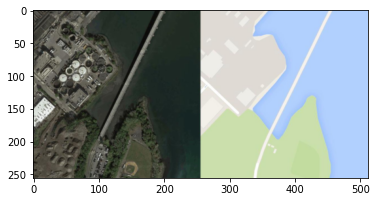

In [ ]:
images,_ = next(iter(dataloader_train))

for image in images:  
  plt.imshow(DeNormalize(image).permute(1,2,0))
  plt.show()
  break;

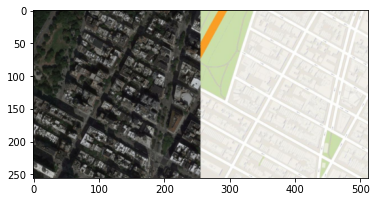

In [ ]:
images,_ = next(iter(dataloader_train))

plt.imshow(DeNormalize(images[5]).permute(1,2,0))
plt.show()

UNet and patchGAN

Training epoch 1


  0%|          | 0/69 [00:00<?, ?it/s]

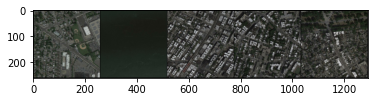

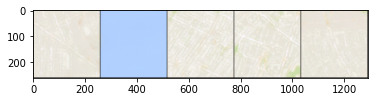

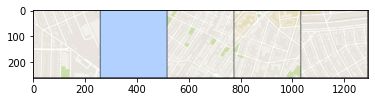

Training epoch 2


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 3


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 4


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 5


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 6


  0%|          | 0/69 [00:00<?, ?it/s]

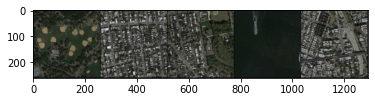

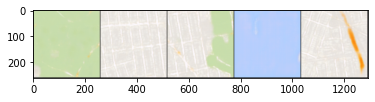

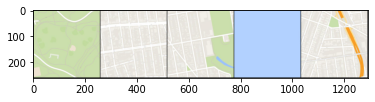

Training epoch 7


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 8


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 9


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 10


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 11


  0%|          | 0/69 [00:00<?, ?it/s]

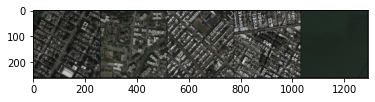

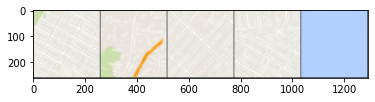

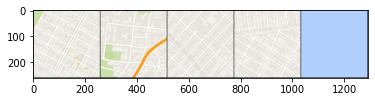

Training epoch 12


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 13


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 14


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 15


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 16


  0%|          | 0/69 [00:00<?, ?it/s]

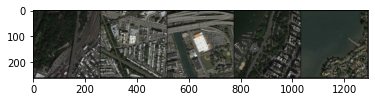

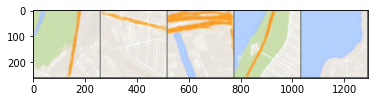

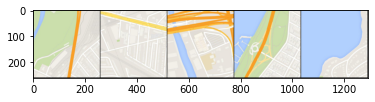

Training epoch 17


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 18


  0%|          | 0/69 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:

for epoch in range(epochs+1):
    print(f"Training epoch {epoch+1}")
    for images,_ in tqdm(dataloader_train):
      # Splitting the image 

      inputs = images[:,:,:,:256].to(device)
      targets = images[:,:,:,256:].to(device)

      # Train Discriminator

      Disc_Loss = disc_training(inputs,targets,disc_opt)

      # Train Geneerator
      for i in range(2):
            Gen_Loss, generator_image = gen_training(inputs,targets, gen_opt, lambda_L1)

    if (epoch % 5) == 0:
        print_images(inputs,5)
        print_images(generator_image,5)
        print_images(targets,5)

In [ ]:
def train_gan(train_dataloader, disc='patchGAN', L1_lambda=100, epochs = 15 ):  
  for epoch in range(epochs+1):
      print(f"Training epoch {epoch+1}")
      for images,_ in tqdm(train_dataloader):
        # Splitting the image 

        inputs = images[:,:,:,:256].to(device)
        targets = images[:,:,:,256:].to(device)

        # Train Discriminator

        Disc_Loss = disc_training(inputs,targets,disc_opt)

        # Train Geneerator
        for i in range(2):
          Gen_Loss, generator_image = gen_training(inputs,targets, gen_opt, L1_lambda)

      if (epoch % 5) == 0:
          print_images(inputs,5)
          print_images(generator_image,5)
          print_images(targets,5)

Training epoch 1


  0%|          | 0/69 [00:00<?, ?it/s]

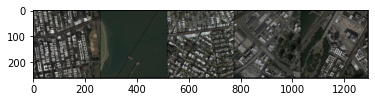

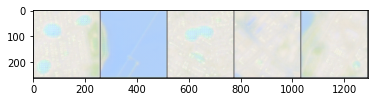

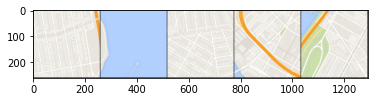

Training epoch 2


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 3


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 4


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 5


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 6


  0%|          | 0/69 [00:00<?, ?it/s]

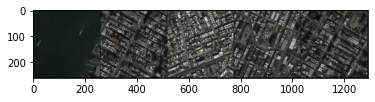

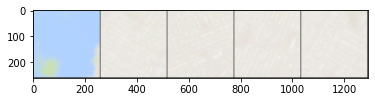

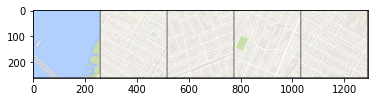

Training epoch 7


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 8


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f43b738aa70>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f43b738aa70>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child processif w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 9


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 10


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 11


  0%|          | 0/69 [00:00<?, ?it/s]

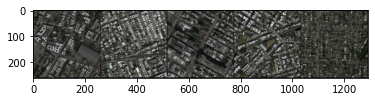

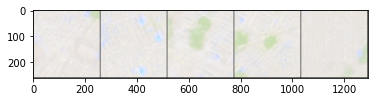

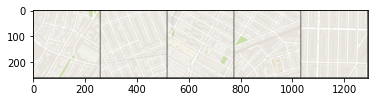

Training epoch 12


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 13


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 14


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 15


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 16


  0%|          | 0/69 [00:00<?, ?it/s]

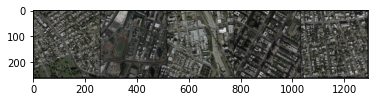

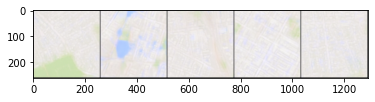

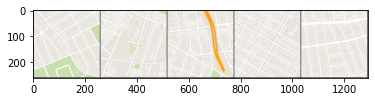

In [ ]:
train_gan(dataloader_train, disc='pixel')

Training epoch 1


  0%|          | 0/69 [00:00<?, ?it/s]

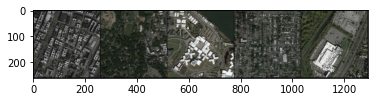

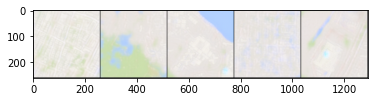

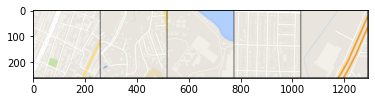

Training epoch 2


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 3


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 4


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 5


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 6


  0%|          | 0/69 [00:00<?, ?it/s]

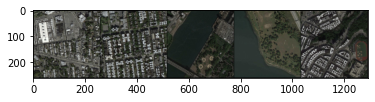

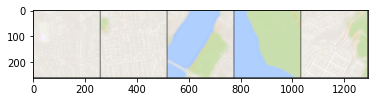

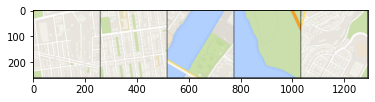

Training epoch 7


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 8


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f43b738aa70>


  0%|          | 0/69 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f43b738aa70>  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        if w.is_alive():self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f43b738aa70>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
assert self._parent_pid == 

Training epoch 9


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 10


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 11


  0%|          | 0/69 [00:00<?, ?it/s]

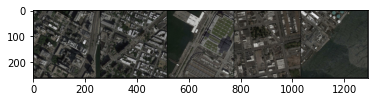

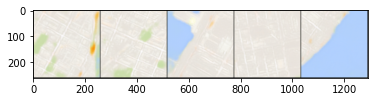

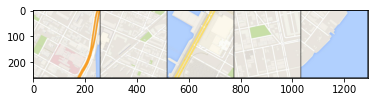

Training epoch 12


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 13


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 14


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 15


  0%|          | 0/69 [00:00<?, ?it/s]

Training epoch 16


  0%|          | 0/69 [00:00<?, ?it/s]

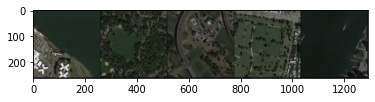

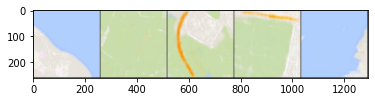

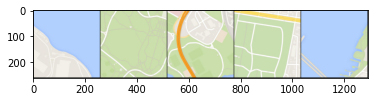

In [ ]:
train_gan('patchGAN', 50)

**On the Cityscapes dataset**

In [ ]:
path2 = '/content/drive/MyDrive/GNR638Project/Datasets/cityscapes'
dataset_train2 = datasets.ImageFolder(root=os.path.join(path2, "Train"), transform=data_transform)
dataset_val2 = datasets.ImageFolder(root=os.path.join(path2, "Val"), transform=data_transform)

dataloader_train2 = torch.utils.data.DataLoader(dataset_train2, batch_size=16, shuffle=True, num_workers=2)
dataloader_val2 = torch.utils.data.DataLoader(dataset_val2, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
def train_gan(dataloader_train2, disc='patchGAN', L1_lambda=100, epochs = 15 )